# 1. Trabalho Prático 2 - Análise de dados de Obras não publicitárias registradas pela Agência Nacional de Cinema

# 2. Membros

Gabriel Camatta Zanotelli - 2018020140

Yaggo Victor Cardoso de Souza Teixeira - 2021086474

Cayo Victor Rocha Guzansky - 2021070802

# 3. Descrição dos dados

Os dados utilizados foram retirados do [portal de dados](https://dados.gov.br/dados/conjuntos-dados/crt-obras-nao-publicitarias-registradas) do governo federal. O conjunto de dados selecionado contém informações como nome, tipo, país de origem e requerente de obras não publicitárias registradas pela Ancine entre 2014 e novembro de 2025.

## Processamento inicial

### Bibliotecas e funções auxiliares

In [3]:
import csv
import pandas as pd
import sqlite3

import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [1]:
def fetch(query, conn, formatted=True):
    # execute the query and fetch all rows
    cur = conn.cursor()
    cur.execute(query)
    rs = cur.fetchall()

    # extract column names from the cursor description
    columns = [desc[0] for desc in cur.description]

    # return a dataframe with column names
    return pd.DataFrame(rs, columns=columns) if formatted else rs

def show_tables(conn):
    return [x[0] for x in fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)]

def shape(table, conn):
    nrows = fetch(f'SELECT COUNT(*) FROM {table}', conn, False)[0][0]
    ncols = fetch(f'SELECT COUNT(*) FROM pragma_table_info("{table}")', conn, False)[0][0]

    return (nrows, ncols)

def desc(table, conn):
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info("{table}")')
    columns = [row[1] for row in cur.fetchall()]

    return columns

def info(table, conn):
    # table constraints (domain, null, default, pk)
    df1 = fetch(f'PRAGMA table_info("{table}")', conn)
    columns = desc(table, conn)

    # entries per column
    counts = ', '.join([f'COUNT(*) AS "{column}"' for column in columns])
    df2 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df2.columns = ['count']

    # non-null entries per column
    counts = ', '.join([f'COUNT("{column}") AS "{column}"' for column in columns])
    df3 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df3.columns = ['notnull count']

    # unique non-null entries per column
    counts = ', '.join([f'COUNT(DISTINCT "{column}") AS "{column}"' for column in columns])
    df4 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df4.columns = ['unique count']

    return df1.merge(df2, left_on='name', right_index=True) \
            .merge(df3, left_on='name', right_index=True) \
            .merge(df4, left_on='name', right_index=True)

def display(urls, cols=5):
    # fetch images
    images = []
    for url in urls:
        response = requests.get(url)
        if response.status_code == 200:
            images.append(Image.open(BytesIO(response.content)))

    # calculate the number of rows
    rows = (len(images) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")  # Hide axes
        else:
            ax.axis("off")  # Hide unused subplots
    plt.tight_layout()
    plt.show()

def hist(data, xlabel='', ylabel='', bins='auto'):
    # convert list of tuples into dataframe
    df = pd.DataFrame(data, columns=['key', 'frequency'])
    # expand the data based on frequencies
    expanded = df.loc[df.index.repeat(df['frequency'])].reset_index(drop=True)

    # plot histogram
    sns.histplot(expanded['key'], bins=bins, kde=False)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

### Extração de dados

Os dados foram extraídos de um aquivo *ancime_dataset.csv*, que é uma junção dos outro 11 arquivos separados pro ano de requisição disponíveis na plataforma.

In [4]:
# source dataset: https://dados.gov.br/dados/conjuntos-dados/crt-obras-nao-publicitarias-registradas
source = './ancine_dataset.csv'

# connect to SQLite database
conn = sqlite3.connect('ancine.db')
cur = conn.cursor()

# set PRAGMA options for faster ingestion
cur.execute('PRAGMA synchronous = OFF')
cur.execute('PRAGMA journal_mode = MEMORY')

# batch size for processing large datasets
BATCH_SIZE = 1000

# begin transaction for bulk ingestion
cur.execute('BEGIN TRANSACTION')

# read the CSV file and ingest in batches
with open(source, 'r', encoding="utf8") as f:
    reader = csv.reader(f, delimiter=';')
    header = next(reader)  # Read the header row

    # create table with appropriate column names
    columns = [f'"{column}"' for column in header]
    create = f'CREATE TABLE IF NOT EXISTS Source ({", ".join(columns)})'
    cur.execute(create)

    # prepare the INSERT query
    placeholders = ', '.join(['?'] * len(header))
    insert = f'INSERT INTO Source VALUES ({placeholders})'

    # process rows in batches
    batch = []
    for row in reader:
        batch.append(row)
        if len(batch) == BATCH_SIZE:
            # Execute batch insert
            cur.executemany(insert, batch)
            # Reset batch
            batch = []

    # insert any remaining rows
    if batch:
        cur.executemany(insert, batch)

# nullify empty values, so they are recognized as proper nulls
update = f'UPDATE Source SET ' + ','.join([f'{column} = NULLIF({column}, "")' for column in columns])
cur.execute(update)

# commit changes
conn.commit()

# reset PRAGMA options (optional but recommended for safety)
cur.execute('PRAGMA synchronous = FULL')
cur.execute('PRAGMA journal_mode = DELETE')

Com o código abaixo podemos verificar que temos 169773 linhas de dados e 22 colunas.

In [8]:
shape('Source', conn)

(165034, 22)

In [6]:
info('Source', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,TITULO_ORIGINAL,,0,None,0,165034,165034,98141
1,1,TITULO_BRASIL,,0,None,0,165034,88209,66274
2,2,CRT,,0,None,0,165034,165034,165034
3,3,DATA_REQUERIMENTO_CRT,,0,None,0,165034,165034,5725
4,4,DATA_EMISSAO_CRT,,0,None,0,165034,165034,4975
5,5,SITUACAO_CRT,,0,None,0,165034,165034,7
6,6,CPB_ROE,,0,None,0,165034,163533,64047
7,7,TIPO_OBRA,,0,None,0,165034,164042,11
8,8,SUBTIPO_OBRA,,0,None,0,165034,43774,4
9,9,CLASSIFICACAO,,0,None,0,165034,165023,5


### Limpeza de dados

Para nossa análise, foram excluídas todas as requisições feitas por pessoas físicas.

In [21]:
# Remove todas as Obras requisitadas por pessoa física, já que vamos usar o CNPJ como a chave do Requerente
cur.execute(f'DELETE FROM Source WHERE CNPJ_REQUERENTE  = "PESSOA FÍSICA"')
conn.commit()

cur.execute(f'DELETE FROM Source WHERE DATA_REQUERIMENTO_CRT NOT LIKE "%/2024" AND DATA_REQUERIMENTO_CRT NOT LIKE "%/2025" AND DATA_REQUERIMENTO_CRT NOT LIKE "%/2023"')
conn.commit()

In [23]:
info('Source', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,TITULO_ORIGINAL,,0,None,0,12522,12522,10181
1,1,TITULO_BRASIL,,0,None,0,12522,3153,3138
2,2,CRT,,0,None,0,12522,12522,12522
3,3,DATA_REQUERIMENTO_CRT,,0,None,0,12522,12522,580
4,4,DATA_EMISSAO_CRT,,0,None,0,12522,12522,515
5,5,SITUACAO_CRT,,0,None,0,12522,12522,3
6,6,CPB_ROE,,0,None,0,12522,12522,10336
7,7,TIPO_OBRA,,0,None,0,12522,12522,11
8,8,SUBTIPO_OBRA,,0,None,0,12522,2192,4
9,9,CLASSIFICACAO,,0,None,0,12522,12522,5


## Migração dos dados

Os dados foram agrupados em 4 tabelas: Requisição, Classificação, Obras e Requerentes.

In [24]:
# Deleta todas as tabelas e seus dados, caso elas já existam
ddl = [
    'DROP TABLE IF EXISTS Requisicao;',
    'DROP TABLE IF EXISTS Classificacao;',
    'DROP TABLE IF EXISTS Obras;',
    'DROP TABLE IF EXISTS Requerentes;'
]

for q in ddl:
    cur.execute(q)

conn.commit()

In [25]:
# Prepara os shcemas

ddl = [
    '''
    CREATE TABLE IF NOT EXISTS Requerentes (
        CNPJ_REQUERENTE TEXT PRIMARY KEY,
        REQUERENTE TEXT NOT NULL,
        REGISTRO_ANCINE_REQUERENTE TEXT,
        UF_REQUERENTE TEXT,
        MUNICIPIO_REQUERENTE TEXT
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Obras (
        CRT TEXT PRIMARY KEY,
        TITULO_ORIGINAL TEXT NOT NULL,
        TITULO_BRASIL TEXT,
        PAIS TEXT,
        ORGANIZACAO_TEMPORAL TEXT,
        DURACAO_TOTAL_MINUTOS INTEGER,
        ANO_PRODUCAO_INICIAL INTEGER,
        ANO_PRODUCAO_FINAL INTEGER,
        SEGMENTO TEXT,
        REDUCAO_ISENCAO TEXT,
        CPB_ROE TEXT
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Classificacao (
        CRT TEXT PRIMARY KEY,
        CLASSIFICACAO TEXT NOT NULL,
        TIPO_OBRA TEXT,
        SUBTIPO_OBRA TEXT,
        FOREIGN KEY (CRT) REFERENCES Obras(CRT)
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Requisicao (
        CRT TEXT,
        CNPJ_REQUERENTE TEXT,
        DATA_REQUERIMENTO_CRT DATE,
        DATA_EMISSAO_CRT DATE,
        SITUACAO_CRT TEXT,
        PRIMARY KEY (CRT, CNPJ_REQUERENTE),
        FOREIGN KEY (CRT) REFERENCES Obras(CRT),
        FOREIGN KEY (CNPJ_REQUERENTE) REFERENCES Requerentes(CNPJ_REQUERENTE)
    );
    '''
]

for q in ddl:
    cur.execute(q)

conn.commit()

#### Migra Requerentes

In [26]:
# migrate Requerentes
cur.execute('DELETE FROM Requerentes')
cur.execute('''
INSERT OR IGNORE INTO Requerentes (
    CNPJ_REQUERENTE, REQUERENTE, REGISTRO_ANCINE_REQUERENTE, UF_REQUERENTE, MUNICIPIO_REQUERENTE
)
SELECT DISTINCT
    CNPJ_REQUERENTE, REQUERENTE, REGISTRO_ANCINE_REQUERENTE, UF_REQUERENTE, MUNICIPIO_REQUERENTE
FROM Source
WHERE CNPJ_REQUERENTE IS NOT NULL AND CNPJ_REQUERENTE != '';''')

conn.commit()
info('Requerentes', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,CNPJ_REQUERENTE,TEXT,0,None,1,1174,1174,1174
1,1,REQUERENTE,TEXT,1,None,0,1174,1174,1174
2,2,REGISTRO_ANCINE_REQUERENTE,TEXT,0,None,0,1174,1174,1174
3,3,UF_REQUERENTE,TEXT,0,None,0,1174,1174,25
4,4,MUNICIPIO_REQUERENTE,TEXT,0,None,0,1174,1174,136


#### Migra Obras

In [27]:
# migrate Obras
cur.execute('DELETE FROM Obras')
cur.execute('''
INSERT INTO Obras (
    CRT, TITULO_ORIGINAL, TITULO_BRASIL, PAIS,
    ORGANIZACAO_TEMPORAL, DURACAO_TOTAL_MINUTOS, ANO_PRODUCAO_INICIAL,
    ANO_PRODUCAO_FINAL, SEGMENTO, REDUCAO_ISENCAO, CPB_ROE
)
SELECT DISTINCT
    CRT, TITULO_ORIGINAL, TITULO_BRASIL, PAIS,
    ORGANIZACAO_TEMPORAL, DURACAO_TOTAL_MINUTOS, ANO_PRODUCAO_INICIAL,
    ANO_PRODUCAO_FINAL, SEGMENTO, REDUCAO_ISENCAO, CPB_ROE
FROM Source
WHERE CRT IS NOT NULL AND CRT != '';''')

conn.commit()
info('Obras', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,CRT,TEXT,0,None,1,12522,12522,12522
1,1,TITULO_ORIGINAL,TEXT,1,None,0,12522,12522,10181
2,2,TITULO_BRASIL,TEXT,0,None,0,12522,3153,3138
3,3,PAIS,TEXT,0,None,0,12522,12521,70
4,4,ORGANIZACAO_TEMPORAL,TEXT,0,None,0,12522,12522,5
5,5,DURACAO_TOTAL_MINUTOS,INTEGER,0,None,0,12522,12522,1919
6,6,ANO_PRODUCAO_INICIAL,INTEGER,0,None,0,12522,12522,89
7,7,ANO_PRODUCAO_FINAL,INTEGER,0,None,0,12522,4057,40
8,8,SEGMENTO,TEXT,0,None,0,12522,12522,5
9,9,REDUCAO_ISENCAO,TEXT,0,None,0,12522,12522,11


### Migra Classificacao

In [28]:
# migrate Classificacao
cur.execute('DELETE FROM Classificacao')
cur.execute('''
INSERT INTO Classificacao (
    CRT, CLASSIFICACAO, TIPO_OBRA, SUBTIPO_OBRA
)
SELECT DISTINCT
    CRT, CLASSIFICACAO, TIPO_OBRA, SUBTIPO_OBRA
FROM Source
WHERE CRT IS NOT NULL AND CRT != '' AND CLASSIFICACAO IS NOT NULL AND CLASSIFICACAO != '';''')

conn.commit()
info('Classificacao', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,CRT,TEXT,0,None,1,12522,12522,12522
1,1,CLASSIFICACAO,TEXT,1,None,0,12522,12522,5
2,2,TIPO_OBRA,TEXT,0,None,0,12522,12522,11
3,3,SUBTIPO_OBRA,TEXT,0,None,0,12522,2192,4


### Migra Requisicao

In [29]:
# migrate Requisicao
cur.execute('DELETE FROM Requisicao')
cur.execute('''
INSERT INTO Requisicao (
    CRT, CNPJ_REQUERENTE, DATA_REQUERIMENTO_CRT, DATA_EMISSAO_CRT, SITUACAO_CRT
)
SELECT DISTINCT
    s.CRT, s.CNPJ_REQUERENTE, s.DATA_REQUERIMENTO_CRT, s.DATA_EMISSAO_CRT, s.SITUACAO_CRT
FROM Source s
WHERE s.CRT IS NOT NULL AND s.CRT != ''
  AND s.CNPJ_REQUERENTE IS NOT NULL AND s.CNPJ_REQUERENTE != '';''')

conn.commit()
info('Requisicao', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,CRT,TEXT,0,None,1,12522,12522,12522
1,1,CNPJ_REQUERENTE,TEXT,0,None,2,12522,12522,1174
2,2,DATA_REQUERIMENTO_CRT,DATE,0,None,0,12522,12522,580
3,3,DATA_EMISSAO_CRT,DATE,0,None,0,12522,12522,515
4,4,SITUACAO_CRT,TEXT,0,None,0,12522,12522,3


### Deleta tabela de origem

In [30]:
# drop source table
cur.execute('DROP TABLE Source;')
conn.commit()

show_tables(conn)

['Requerentes', 'Obras', 'Classificacao', 'Requisicao']

# 4. Diagrama ER

![Diagrama ER](./diagrama_er.png)

# 5. Diagrama relacional

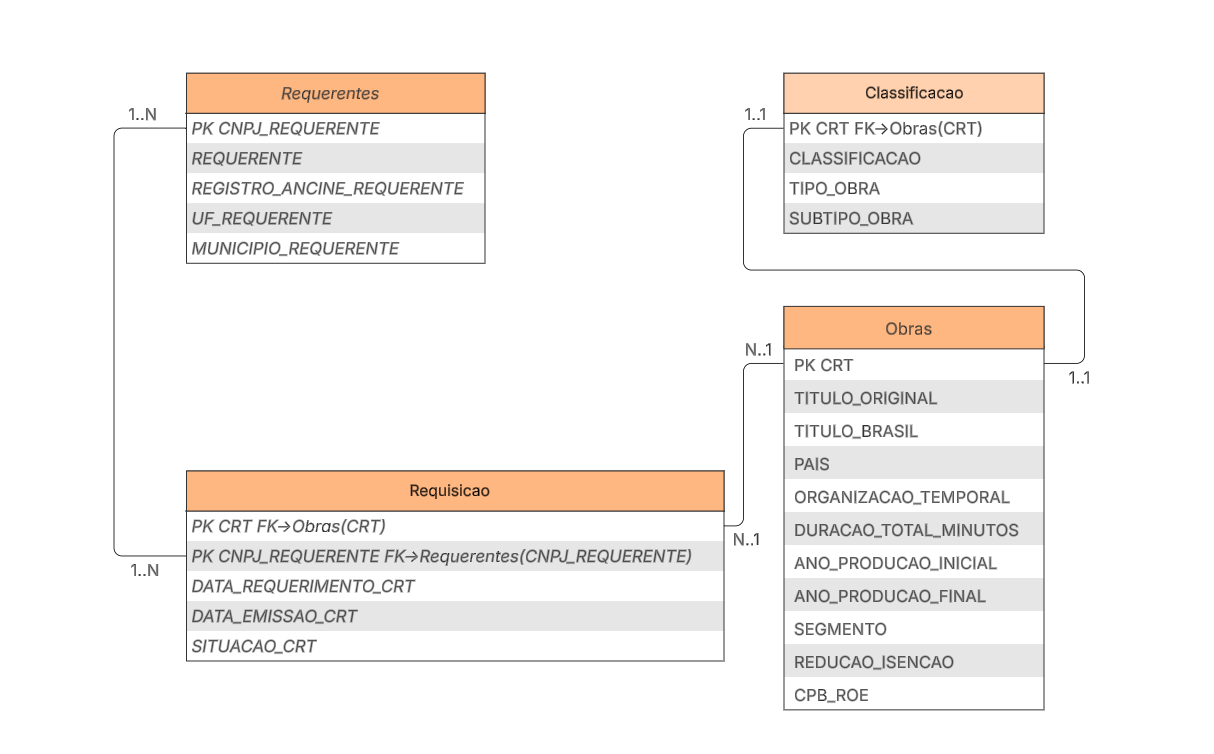

# 6. Consultas

As seguintes consultas foram desenvolvidas sobre o banco normalizado contendo as tabelas Obras, Requerentes, Classificacao e Requisicao.
Cada consulta apresenta uma explicação textual, seguida do comando SQL e do bloco Python utilizado para executar no SQLite dentro do notebook.

## 6.1 Duas consultas envolvendo seleção e projeção

6.1.1 — Seleção de obras produzidas em 2005

Objetivo: listar obras cujo ano de produção inicial é 2005, exibindo somente título original e país.

In [ ]:
sql1 = """
SELECT TITULO_ORIGINAL, PAIS
FROM Obras
WHERE ANO_PRODUCAO_INICIAL = 2005
LIMIT 50;
"""
fetch(sql1, conn)

### 6.1.2 Consulta 2

6.1.2 — Seleção de requisições com situação 'IRREGULAR'

Objetivo: listar requisições irregulares, projetando apenas algumas colunas essenciais.

In [ ]:
sql2 = """
SELECT CRT, CNPJ_REQUERENTE, SITUACAO_CRT, DATA_REQUERIMENTO_CRT
FROM Requisicao
WHERE SITUACAO_CRT = 'IRREGULAR'
LIMIT 50;
"""
fetch(sql2, conn)

## 6.2 Três consultas envolvendo junção de duas relações

6.2.1 — Requisições com título da obra

Objetivo: obter o título brasileiro das obras junto da situação da requisição.

In [ ]:
sql3 = """
SELECT r.CRT, o.TITULO_BRASIL, r.SITUACAO_CRT
FROM Requisicao r
JOIN Obras o ON r.CRT = o.CRT
LIMIT 50;
"""
fetch(sql3, conn)

6.2.2 — Requerentes e suas requisições

Objetivo: mostrar o total de pedidos de requisição feitos por cada requerente 

In [ ]:
sql4 = """
SELECT r.id, r.nome_requerente, COUNT(req.CRT) AS total_requisicoes
FROM Requerente r
JOIN Requisicao req ON r.cnpj = req.CNPJ_REQUERENTE
GROUP BY r.id, r.nome_requerente
ORDER BY total_requisicoes DESC
LIMIT 50;
"""
fetch(sql4, conn)


6.2.3 — Obras e suas classificações

Objetivo: mostrar os tipos de obra e quantas obras existem por cada tipo.

In [ ]:
sql5 = """
SELECT c.TIPO_OBRA, COUNT(o.CRT) AS total_obras
FROM Classificacao c
JOIN Obras o ON c.CRT = o.CRT
GROUP BY c.TIPO_OBRA
ORDER BY total_obras DESC;
"""
fetch(sql5, conn)

## 6.3 Três consultas envolvendo junção de três ou mais relações

6.3.1 — Obras, requerentes e suas situação

Objetivo: relacionar obras + requisicao + requerentes

In [ ]:
sql6 = """
SELECT o.TITULO_BRASIL, req.REQUERENTE, r.SITUACAO_CRT
FROM Requisicao r
JOIN Obras o ON r.CRT = o.CRT
JOIN Requerentes req ON r.CNPJ_REQUERENTE = req.CNPJ_REQUERENTE
LIMIT 50;
"""
fetch(sql6, conn)

6.3.2 — Tipo, segmento e quantidade

Objetivo: relacionar requisição + classificação + obras - Quantidade de obras por seguimento

In [ ]:
sql7 = """
SELECT c.TIPO_OBRA, o.SEGMENTO, COUNT(*) AS qtd
FROM Requisicao r
JOIN Obras o ON r.CRT = o.CRT
JOIN Classificacao c ON o.CRT = c.CRT
GROUP BY c.TIPO_OBRA, o.SEGMENTO
ORDER BY qtd DESC
LIMIT 50;
"""
fetch(sql7, conn)

6.3.3 — Município, requerente, e quantidade de requisições

Objetivo: relacionar requisição + requerentes + obras - Quantidade de requisições por requerente por município

In [ ]:
sql8 = """
SELECT req.MUNICIPIO_REQUERENTE, req.REQUERENTE, COUNT(r.CRT) AS qtd_requisicoes
FROM Requisicao r
JOIN Requerentes req ON r.CNPJ_REQUERENTE = req.CNPJ_REQUERENTE
JOIN Obras o ON r.CRT = o.CRT
GROUP BY req.MUNICIPIO_REQUERENTE, req.REQUERENTE
ORDER BY qtd_requisicoes DESC
LIMIT 50;
"""
fetch(sql8, conn)

## 6.4 Duas consultas envolvendo agregação sobre junção de duas ou mais relações

6.4.1 — Análise regional a partir da tabela de requerentes (Requerente + Requisicao)

Objetivo: total de requisições por cidade

In [ ]:
sql9 = """
SELECT req.MUNICIPIO_REQUERENTE, req.UF_REQUERENTE, COUNT(*) AS total_requisicoes
FROM Requisicao r
JOIN Requerentes req ON r.CNPJ_REQUERENTE = req.CNPJ_REQUERENTE
GROUP BY req.MUNICIPIO_REQUERENTE, req.UF_REQUERENTE
ORDER BY total_requisicoes DESC
LIMIT 20;
"""
fetch(sql9, conn)

6.4.2 — Busca por segmento e situação das requisições (Obras + Requisicao)

Objetivo: análise sobre a quantidade e situação das obras separadas por segmento

In [ ]:
sql10 = """
SELECT o.SEGMENTO, r.SITUACAO_CRT, COUNT(*) AS qtd
FROM Requisicao r
JOIN Obras o ON r.CRT = o.CRT
GROUP BY o.SEGMENTO, r.SITUACAO_CRT
ORDER BY o.SEGMENTO, qtd DESC
LIMIT 200;
"""
fetch(sql10, conn)

# 7. Autoavaliação dos membros

### Finalização do ambiente

In [10]:
cur.close()
conn.close()